In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [39]:
# 株価データの取得
ticker = '9434.T'  # ソフトバンクのティッカーシンボル
data = yf.Ticker(ticker)
hist = data.history(period="1y")  # 過去1年分のデータを取得

# データの前処理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(hist['Close'].values.reshape(-1, 1))

# 訓練データとテストデータの作成
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# データの形状をLSTMに適した形に変換
print(X_test.shape)  # 形状を確認
if len(X_test.shape) == 1:
    X_test = X_test.reshape(X_test.shape[0], 1, 1)
else:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# LSTMモデルの構築
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# モデルのコンパイルと訓練
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=1)

# 1か月分の株価の予測
future_days = 30
predictions = []
last_60_days = scaled_data[-60:]

for _ in range(future_days):
    X_predict = last_60_days.reshape(1, -1, 1)
    predicted_price = model.predict(X_predict)
    predictions.append(predicted_price[0, 0])
    last_60_days = np.append(last_60_days[1:], predicted_price)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

(0,)


C:\Users\ryota\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: object __array__ method not producing an array

In [35]:
print(X_test.shape)

(0,)


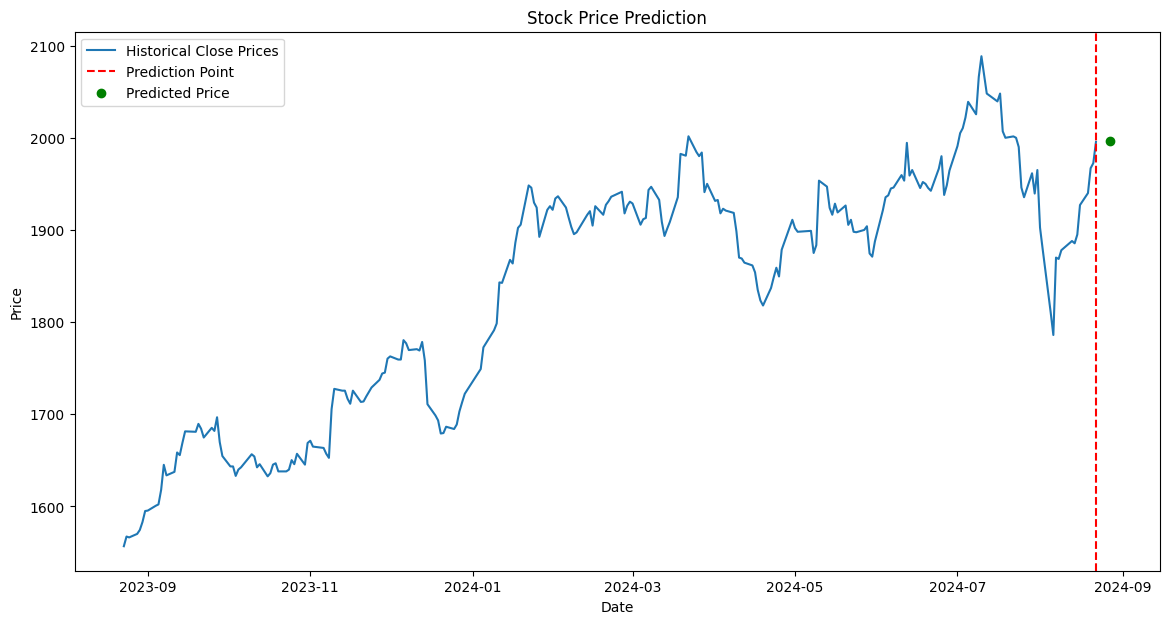

In [ ]:
# グラフの作成
plt.figure(figsize=(14, 7))
plt.plot(hist.index, hist['Close'], label='Historical Close Prices')
plt.axvline(x=hist.index[-1], color='r', linestyle='--', label='Prediction Point')
plt.scatter(tomorrow_date, tomorrow_price, color='g', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()